**In this notebook we process data for analysis into the necessary file types and filter for cells**

In [121]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [253]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [254]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## **Benchmarking Datasets**

### **Allen Institute Brain Data**

Single-cell and single-nucleus data from BICCN MOP data

Need to process fastqs for single-nuc data from multiple samples (sequenced together)

In [264]:
#Raw single-cell A08 10xv3 brain sample from https://zenodo.org/records/10530877

a08 = lp.connect('/home/tchari/counts/allen_bivi/loom/allen_A08_raw.loom')
bars = a08.ca['barcode']
print(bars[0])
genes = a08.ra['gene_name']
U = a08.layers['unspliced'][:,:]
S = a08.layers['spliced'][:,:]
print(S.shape)

AAACCCAAGAGGCTGT
(32285, 9974)


In [265]:
a08.close()

In [266]:
meta_a08 = pd.read_csv('/home/tchari/metadata/allen_sc_sample_metadata.csv')
meta_a08.head()

,Unnamed: 0,aggr_num,umi.counts,gene.counts,library_id,tube_barcode,Seq_batch,Region,Lib_type,Gender,...,Live_percent,Total_Cells,Live_Cells,method,exp_component_name,mapped_reads,unmapped_reads,nonconf_mapped_reads,total.reads,doublet.score
0,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,1,55812,7122,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,141238,2460,11355,155053.0,0.154639
1,AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,1,1670,668,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,4160,64,1049,5273.0,0.030928
2,AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,1,1873,406,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,6404,47,2539,8990.0,0.000000
3,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,1,36622,6125,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,90968,1351,7997,100316.0,0.163265
4,AAACCCACACCAGCCA-1L8TX_181211_01_G12,1,90475,8322,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCACACCAGCCA-1L8TX_181211_01_G12,240181,4107,20590,264878.0,0.164948


In [267]:
a08_members = pd.read_csv('/home/tchari/metadata/allen_sc_cluster.membership.csv')
a08_annots =  pd.read_csv('/home/tchari/metadata/allen_sc_cluster.annotation.csv')
a08_annots.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
0,1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,81
1,2,Lamp5 Egln3_2_1,Lamp5,GABAergic,#DD8091,179
2,3,Lamp5 Pdlim5_1,Lamp5,GABAergic,#FF829E,247
3,4,Lamp5 Pdlim5_2,Lamp5,GABAergic,#FF7290,537
4,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275


In [268]:
sub_meta = meta_a08[meta_a08.library_id.isin(['L8TX_190430_01_A08'])]
types = ['L5 IT','L6 CT','L2/3 IT','L6 IT','Vip','Sst','L5/6 NP','Lamp5','Pvalb','L6b']

sublab = []
classlab = []
bars_filt = []
for b in list(sub_meta['Unnamed: 0']):
    ind = a08_members['Unnamed: 0'] == b
    if np.sum(ind) >0:
        lab = list(a08_members['x'][ind])[0]

        ind2 = a08_annots['cluster_id'] == lab
        testlab = list(a08_annots['subclass_label'][ind2])[0]
        if (testlab in types): #Remove types < 10 cells/low quality
            sublab += list(a08_annots['subclass_label'][ind2])
            classlab += list(a08_annots['class_label'][ind2])

            bars_filt += [b[:b.index('-')]]
    

In [269]:
len(bars_filt)

5693

In [270]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = bars_filt

In [271]:
#Save as loom with raw counts, test saving as h5
!mkdir /home/tchari/counts/allen_bivi/loom/

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_filt,'subclass_label':sublab,'class_label':classlab},
                             index=bars_filt),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom')

#Another notebook for converting looms to SeuratData for WNN

mkdir: cannot create directory ‘/home/tchari/counts/allen_bivi/loom/’: File exists


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [61]:
# test = lp.connect('/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom')
# test.ca.keys()
# test.close()

['barcode', 'class_label', 'obs_names', 'subclass_label']

In [97]:
# #Test writing h5 file for scMDC and scDeepCluster
# hf = h5py.File('data.h5', 'w')
# hf.create_dataset('X1', data=U_sub.T)
# hf.create_dataset('X2', data=S_sub.T)
# hf.create_dataset('Y', data=sublab)
# hf.close()

# test = h5py.File('data.h5')
# test.keys()
# test.close()

Single-nucleus BICCN data processing

In [165]:
#Get metadata from https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/processed/analysis/10X_nuclei_v3_AIBS/

meta_nuc = pd.read_csv('/home/tchari/metadata/allen_nuc_sample_metadata.csv')
nuc_members = pd.read_csv('/home/tchari/metadata/allen_nuc_cluster.membership.csv')
nuc_annots =  pd.read_csv('/home/tchari/metadata/allen_nuc_cluster.annotation.csv')
nuc_annots.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
0,1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,65
1,2,Lamp5 Egln3,Lamp5,GABAergic,#DD8091,105
2,3,Lamp5 Pdlim5,Lamp5,GABAergic,#FF7290,257
3,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,484
4,5,Lamp5 Lhx6,Lamp5,GABAergic,#C77963,39


(array([9.179e+03, 5.116e+03, 2.253e+03, 5.710e+02, 1.710e+02, 5.200e+01,
        1.800e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([   779. ,  11279.2,  21779.4,  32279.6,  42779.8,  53280. ,
         63780.2,  74280.4,  84780.6,  95280.8, 105781. ]),
 <BarContainer object of 10 artists>)

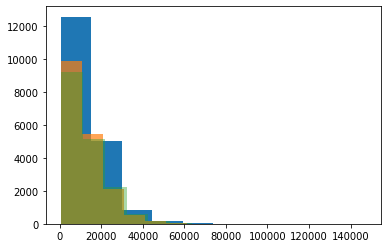

In [189]:
plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_A02'])])
plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_B02'])],alpha=0.7)
#plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_D02'])],alpha=0.5)
plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_H01'])],alpha=0.4)
#plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_C02'])],alpha=0.5)

In [ ]:
#Get fastqs from https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/
#For B02 and H01
#https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/L8TX_181211_01_B02_S01_L003.fastq.tar
#https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/L8TX_181211_01_H01_S01_L003.fastq.tar


# generate count matrices from allen data 
# allen B02 (nuclear)
! kb count --verbose \
-i /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt \
-x 10xv3 \
-o /home/tchari/counts/allen_bivi/B02/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/allen_bivi/L8TX_181211_01_B02_S01_L003/L8TX_181211_01_B02_S01_L003_R1_001.fastq.gz \
/home/tchari/counts/allen_bivi/L8TX_181211_01_B02_S01_L003/L8TX_181211_01_B02_S01_L003_R2_001.fastq.gz


In [ ]:
# allen H01 (nuclear)
! kb count --verbose \
-i /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt \
-x 10xv3 \
-o /home/tchari/counts/allen_bivi/H01/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/allen_bivi/L8TX_181211_01_H01_S01_L003/L8TX_181211_01_H01_S01_L003_R1_001.fastq.gz \
/home/tchari/counts/allen_bivi/L8TX_181211_01_H01_S01_L003/L8TX_181211_01_H01_S01_L003_R2_001.fastq.gz


In [177]:
#Filter for cells in annotation
type_counts = dict()
for s in list(pd.unique(nuc_annots.subclass_label)):
    type_counts[s] = np.sum(np.array(nuc_annots['size'][nuc_annots.subclass_label.isin([s])]))
    
type_counts

{'Lamp5': 950,
 'Sncg': 192,
 'Vip': 1092,
 'Sst': 1692,
 'Pvalb': 2600,
 'L2/3 IT': 8043,
 'L5 IT': 11599,
 'L6 IT': 2177,
 'L5 ET': 1244,
 'L5/6 NP': 1503,
 'L6 CT': 7955,
 'L6b': 659,
 'Astro': 163,
 'Macrophage': 54,
 'OPC': 77,
 'Oligo': 143,
 'Endo': 23,
 'Doublet': 253,
 'Outside Mop': 27,
 'Low Quality': 109}

In [168]:
#Read in looms from kb
sub_meta = meta_nuc[meta_nuc.library_id.isin(['L8TX_181211_01_B02'])]
print(sub_meta.head())

b02 = lp.connect('/home/tchari/counts/allen_bivi/B02/counts_unfiltered/adata.loom')
bars = b02.ca['barcode']
print(bars[0])
genes = b02.ra['gene_name']
U = b02.layers['unspliced'][:,:]
S = b02.layers['spliced'][:,:]
print(S.shape)

b02.close()

                                 Unnamed: 0  aggr_num  umi.counts  \
18559  AAACCCAAGATCCTAC-2L8TX_181211_01_B02         2         688   
18560  AAACCCAAGCATACTC-2L8TX_181211_01_B02         2         684   
18561  AAACCCAAGCCTGAGA-2L8TX_181211_01_B02         2       10112   
18562  AAACCCACACCATATG-2L8TX_181211_01_B02         2         740   
18563  AAACCCACACCCAACG-2L8TX_181211_01_B02         2         793   

       gene.counts          library_id tube_barcode Seq_batch Region  \
18559          340  L8TX_181211_01_B02   SM-HH8FP-9   RTX-841    MOp   
18560          338  L8TX_181211_01_B02   SM-HH8FP-9   RTX-841    MOp   
18561         2578  L8TX_181211_01_B02   SM-HH8FP-9   RTX-841    MOp   
18562          369  L8TX_181211_01_B02   SM-HH8FP-9   RTX-841    MOp   
18563          419  L8TX_181211_01_B02   SM-HH8FP-9   RTX-841    MOp   

               Lib_type  Gender  ...  Live_percent Total_Cells Live_Cells  \
18559  Nuclei_FACS-NeuN  Female  ...           NaN         NaN        NaN  

In [181]:
##### OR JUST DO THE TOP 10 CLUSTERS
sublab = []
classlab = []
bars_filt = []

types = ['Lamp5','Vip','Sst','Pvalb','L2/3 IT',
         'L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b']

for b in list(sub_meta['Unnamed: 0']):
    ind = nuc_members['Unnamed: 0'] == b
    if np.sum(ind) >0:
        lab = list(nuc_members['x'][ind])[0]

        ind2 = nuc_annots['cluster_id'] == lab
        testlab = list(nuc_annots['subclass_label'][ind2])[0]
        if (testlab in types): #Remove types > 50 cells per sample (250 cells total)
            sublab += list(nuc_annots['subclass_label'][ind2])
            classlab += list(nuc_annots['class_label'][ind2])

            bars_filt += [b[:b.index('-')]]
            
print(len(bars_filt))

7792


In [182]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = [i+'_B02' for i in bars_filt]

In [183]:
#Read in looms from kb (H01 sample)
sub_meta = meta_nuc[meta_nuc.library_id.isin(['L8TX_181211_01_H01'])]
print(sub_meta.head())

h01 = lp.connect('/home/tchari/counts/allen_bivi/H01/counts_unfiltered/adata.loom')
bars_h = h01.ca['barcode']
print(bars_h[0])
genes_h = h01.ra['gene_name']
U_h = h01.layers['unspliced'][:,:]
S_h = h01.layers['spliced'][:,:]
print(S.shape)

h01.close()

                                 Unnamed: 0  aggr_num  umi.counts  \
72899  AAACCCAAGAGTGTGC-5L8TX_181211_01_H01         5       19480   
72900  AAACCCAAGTCGCCCA-5L8TX_181211_01_H01         5       13598   
72901  AAACCCAAGTGCACAG-5L8TX_181211_01_H01         5         878   
72902  AAACCCAAGTTTGTCG-5L8TX_181211_01_H01         5       16337   
72903  AAACCCACAACCAATC-5L8TX_181211_01_H01         5         905   

       gene.counts          library_id tube_barcode Seq_batch Region  \
72899         3939  L8TX_181211_01_H01   SM-HPZA3-4   RTX-842    MOp   
72900         3100  L8TX_181211_01_H01   SM-HPZA3-4   RTX-842    MOp   
72901          423  L8TX_181211_01_H01   SM-HPZA3-4   RTX-842    MOp   
72902         3220  L8TX_181211_01_H01   SM-HPZA3-4   RTX-842    MOp   
72903          441  L8TX_181211_01_H01   SM-HPZA3-4   RTX-842    MOp   

               Lib_type  Gender  ...  Live_percent Total_Cells Live_Cells  \
72899  Nuclei_FACS-NeuN  Female  ...           NaN         NaN        NaN  

In [184]:
#Filter for cell barcodes

sublab_h = []
classlab_h = []
bars_filt_h = []

types = ['Lamp5','Vip','Sst','Pvalb','L2/3 IT',
         'L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b']

for b in list(sub_meta['Unnamed: 0']):
    ind = nuc_members['Unnamed: 0'] == b
    if np.sum(ind) >0:
        lab = list(nuc_members['x'][ind])[0]

        ind2 = nuc_annots['cluster_id'] == lab
        testlab = list(nuc_annots['subclass_label'][ind2])[0]
        if (testlab in types): #Remove types > 50 cells per sample (250 cells total)
            sublab_h += list(nuc_annots['subclass_label'][ind2])
            classlab_h += list(nuc_annots['class_label'][ind2])

            bars_filt_h += [b[:b.index('-')]]
            
print(len(bars_filt_h))

7469


In [185]:
filt_inds_h = [list(bars_h).index(b) for b in bars_filt_h]
U_sub_h = U_h[:,filt_inds_h]
S_sub_h = S_h[:,filt_inds_h]
bars_sub_h = [i+'_H01' for i in bars_filt_h]

In [201]:
#Save loom

retAdata = anndata.AnnData(
			X=np.concatenate([S_sub,S_sub_h],axis=1).T,
			layers={
				'spliced': np.concatenate([S_sub,S_sub_h],axis=1).T,
				'unspliced': np.concatenate([U_sub,U_sub_h],axis=1).T
			},
			obs=pd.DataFrame({'barcode': bars_sub+bars_sub_h,'subclass_label':sublab+sublab_h,
                              'class_label':classlab+classlab_h},
                             index=bars_sub+bars_sub_h),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01_raw.loom')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### **scMixology Benchmark Datasets**

Need to generate from fastqs, original study only does exon-mapping (S only), 10xv2, Human

In [ ]:
#5 cell line mix, GSM3618014
!prefetch SRR8606521 --max-size 30000000000 -O ./ && fasterq-dump --include-technical --split-files SRR8606521

In [ ]:
#3 cell line mix (should concatenate R1s and R2s), GSM3022245

!~/sratoolkit.3.0.7-ubuntu64/bin/prefetch SRR6782109 --max-size 10000000000 -O ./ &&  ~/sratoolkit.3.0.7-ubuntu64/bin/fasterq-dump --include-technical --split-files SRR6782109 

!~/sratoolkit.3.0.7-ubuntu64/bin/prefetch SRR6782110 --max-size 10000000000 -O ./ &&  ~/sratoolkit.3.0.7-ubuntu64/bin/fasterq-dump --include-technical --split-files SRR6782110 

!~/sratoolkit.3.0.7-ubuntu64/bin/prefetch SRR6782111 --max-size 10000000000 -O ./ &&  ~/sratoolkit.3.0.7-ubuntu64/bin/fasterq-dump --include-technical --split-files SRR6782111 

!~/sratoolkit.3.0.7-ubuntu64/bin/prefetch SRR6782112 --max-size 10000000000 -O ./ &&  ~/sratoolkit.3.0.7-ubuntu64/bin/fasterq-dump --include-technical --split-files SRR6782112 




In [ ]:
#5 cell line
! kb count --verbose \
-i /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-GRCh38-2020-A/t2g_grch38.txt \
-x 10xv2 \
-o /home/tchari/counts/scMix/cl5 \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/scMix/SRR8606521_1.fastq \
/home/tchari/counts/scMix/SRR8606521_2.fastq


In [ ]:
#3 cell line

! kb count --verbose \
-i /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-GRCh38-2020-A/t2g_grch38.txt \
-x 10xv2 \
-o /home/tchari/counts/scMix/cl3 \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/scMix/SRR6782109_1.fastq \
/home/tchari/counts/scMix/SRR6782109_2.fastq \
/home/tchari/counts/scMix/SRR6782110_1.fastq \
/home/tchari/counts/scMix/SRR6782110_2.fastq \
/home/tchari/counts/scMix/SRR6782111_1.fastq \
/home/tchari/counts/scMix/SRR6782111_2.fastq


In [159]:
#5 cell line 10x metadata
#metadata from https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3618014_10x_5cl_metadata.csv
#https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/barcode_10x_5cl.csv

cl5_bars = pd.read_csv('/home/tchari/metadata/barcode_10x_5cl.csv',header=0)
print(cl5_bars.head())

cl5_meta = pd.read_csv('/home/tchari/metadata/GSM3618014_10x_5cl_metadata.csv')
cl5_meta.head()

     cell_name  barcode_sequence  count
0  Lib90_00000  CACACAAAGCTAAGAT   4149
1  Lib90_00001  TCAACGAGTTACGTCA   4013
2  Lib90_00002  GACTACAAGGGCTCTC   3771
3  Lib90_00003  GAAATGACACTCGACG   3535
4  Lib90_00004  CACATAGTCCGTCATC   3476


,cell_name,cell_line_demuxlet,demuxlet_cls
0,Lib90_02792,H1975,SNG
1,Lib90_00549,H1975,SNG
2,Lib90_00952,H8383,SNG
3,Lib90_01575,H8383,SNG
4,Lib90_03320,H2228,SNG


In [ ]:
#Read in looms from kb
cl5_adata = lp.connect('/home/tchari/counts/scMix/cl5/counts_unfiltered/adata.loom')
bars = cl5_adata.ca['barcode']
print(bars[0])
genes = cl5_adata.ra['gene_name']
U = cl5_adata.layers['unspliced'][:,:]
S = cl5_adata.layers['spliced'][:,:]
print(S.shape)
#(36601, 159397)
cl5_adata.close()

In [211]:
#Filter for cells with annots
sublab = []
bars_filt = []

for b,c in zip(list(cl5_bars['barcode_sequence']),list(cl5_bars['cell_name'])):
    ind = cl5_meta['cell_name'].isin([c])
    if np.sum(ind) > 0:
        lab = list(cl5_meta['cell_line_demuxlet'][ind])[0]

        sublab += [lab]

        bars_filt += [b]
            
print(len(bars_filt))

4947


In [214]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = bars_filt
print(U_sub.shape)

#Save loom
!mkdir /home/tchari/counts/scMix/cl5/loom

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_sub,'subclass_label':sublab},
                             index=bars_sub),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/scMix/cl5/loom/processed_cl5_raw.loom')


(36601, 4947)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [337]:
#3 cell line 10x metadata
#Metadata from https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3022245_10x_3cl_metadata.csv
#https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3022245_index_anno.csv


cl3_bars = pd.read_csv('/home/tchari/metadata/GSM3022245_index_anno.csv',header=None)
print(cl3_bars.head())
cl3_meta = pd.read_csv('/home/tchari/metadata/GSM3022245_10x_3cl_metadata.csv')
cl3_meta.head()

             0                 1       2
0  CELL_000000  CCTTACGAGGACACCA  864365
1  CELL_000001  CCGTTCAGTACGACCC  755167
2  CELL_000002  TGAAAGACACTGTTAG  753727
3  CELL_000003  CTGAAACAGAGACTAT  750591
4  CELL_000004  GACTGCGCACGAAACG  718276


,cell_name,cell_line_demuxlet,demuxlet_cls
0,CELL_001266,H1975,SNG
1,CELL_001391,H2228,DBL
2,CELL_002843,HCC827,DBL
3,CELL_000432,H2228,SNG
4,CELL_001720,HCC827,DBL


In [338]:
cl3_meta['cell_line_demuxlet'].value_counts()

HCC827    1802
H1975     1519
H2228      645
A549        24
H8383        3
Name: cell_line_demuxlet, dtype: int64

In [339]:
#Read in looms from kb
cl3_adata = lp.connect('/home/tchari/counts/scMix/cl3/counts_unfiltered/adata.loom')
bars = cl3_adata.ca['barcode']
print(bars[0])
genes = cl3_adata.ra['gene_name']
U = cl3_adata.layers['unspliced'][:,:]
S = cl3_adata.layers['spliced'][:,:]
print(S.shape)
cl3_adata.close()

AAACCTGAGAACTCGG
(36601, 136499)


In [340]:
#Filter for cells with annots
sublab = []
bars_filt = []

for b,c in zip(list(cl3_bars[1]),list(cl3_bars[0])):
    ind = cl3_meta['cell_name'].isin([c])
    if (np.sum(ind) > 0) and (b in bars): #Some barcodes not in kb bars
        lab = list(cl3_meta['cell_line_demuxlet'][ind])[0]
        
        if lab in ['HCC827','H1975','H2228']:

            sublab += [lab]

            bars_filt += [b]
            
print(len(bars_filt))

3934


In [343]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = bars_filt
print(U_sub.shape)

#Save loom
!mkdir /home/tchari/counts/scMix/cl3/loom

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_sub,'subclass_label':sublab},
                             index=bars_sub),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/scMix/cl3/loom/processed_cl3_raw.loom')


(36601, 3934)
mkdir: cannot create directory ‘/home/tchari/counts/scMix/cl3/loom’: File exists


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## **Exploratory Datasets**

### **Mouse Breast Cancer Data**

Process from fastqs to get U/S, 10xv2, Genes will be HVGs + 
Breast cancer marker genes

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3045364/ (markers)

In [ ]:
#BRCA1null tumor data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4023823

!prefetch SRR9938469 --max-size 30000000000 -O ./ && fasterq-dump --include-technical --split-files SRR9938469

!prefetch SRR9938470 --max-size 30000000000 -O ./ && fasterq-dump --include-technical --split-files SRR9938470


In [164]:
#Metadata https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4023nnn/GSM4023823/suppl/GSM4023823%5FBRCA1%5FB%5Fbarcodes.tsv.gz
#GSM4023823_BRCA1_B_barcodes.tsv

brca1_bars = pd.read_csv('/home/tchari/metadata/GSM4023823_BRCA1_B_barcodes.tsv',header=None,delimiter='\t')
brca1_bars.head()

,0
0,AAACCTGAGCGAAGGG-1
1,AAACCTGCAAAGGAAG-1
2,AAACCTGGTATATGGA-1
3,AAACCTGGTCCGAGTC-1
4,AAACCTGTCAACGGGA-1


In [ ]:
!kb count --verbose \
-i /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt \
-x 10xv2 \
-o /home/tchari/counts/breast_cancer_mm/brca1 \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/breast_cancer_mm/SRR9938469_1.fastq \
/home/tchari/counts/breast_cancer_mm/SRR9938469_2.fastq \
/home/tchari/counts/breast_cancer_mm/SRR9938470_1.fastq  \
/home/tchari/counts/breast_cancer_mm/SRR9938470_2.fastq


In [225]:
#Read in looms from kb
brca1_adata = lp.connect('/home/tchari/counts/breast_cancer_mm/brca1/counts_unfiltered/adata.loom')
bars = brca1_adata.ca['barcode']
print(bars[0])
genes = brca1_adata.ra['gene_name']
U = brca1_adata.layers['unspliced'][:,:]
S = brca1_adata.layers['spliced'][:,:]
print(S.shape)
brca1_adata.close()

AAACCTGAGAACAACT
(32285, 121183)


In [226]:
bars2 = [i+'-1' for i in list(bars)]
filt_inds = [list(bars2).index(b) for b in list(brca1_bars[0])]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = list(brca1_bars[0])
print(U_sub.shape)

#Save loom
!mkdir /home/tchari/counts/breast_cancer_mm/brca1/loom

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_sub},
                             index=bars_sub),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/breast_cancer_mm/brca1/loom/processed_brca1_raw.loom')


(32285, 2810)


### **10x 10k PBMC Dataset**

From 10x Genomics, minimal annotations, 10xv3, Human, Genes = literature annotation of PBMC-relevant markers

In [228]:
#********* Link to data download: *********
ds = lp.connect('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom')
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']
bars = ds.ca['barcode']
ds.close()

In [233]:
# ********* LINK to metadata download *********

cluster_assignments = pd.read_csv(f'/home/tchari/metadata/pbmc_10k_v3_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
print(cluster_assignments['Barcode'].str[-1:].unique())
cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
cluster_annotations = cluster_assignments

['1']


In [234]:
clus_names = dict(zip([1,2,3,4],['Tcells','Monocytes','Bcells','Other']))
cluster_annotations['Cluster_name'] = [clus_names[i] for i in cluster_annotations['Cluster']]
cluster_annotations.head()

,Barcode,Cluster,Cluster_name
0,AAACCCAAGCGCCCAT,1,Tcells
1,AAACCCAAGGTTCCGC,2,Monocytes
2,AAACCCACAGAGTTGG,2,Monocytes
3,AAACCCACAGGTATGG,1,Tcells
4,AAACCCACATAGTCAC,3,Bcells


In [237]:
# Filter barcodes
sublab = []
bars_filt = []

for b in list(bars):
    ind = cluster_annotations['Barcode'].isin([b])
    if (np.sum(ind) > 0): #Some barcodes not in kb bars
        lab = list(cluster_annotations['Cluster_name'][ind])[0]

        sublab += [lab]

        bars_filt += [b]
            
print(len(bars_filt))

11536


In [238]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = u[:,filt_inds]
S_sub = s[:,filt_inds]
bars_sub = bars_filt
print(U_sub.shape)

#Save loom
!mkdir /home/tchari/counts/10x_pbmcs/loom

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_sub},
                             index=bars_sub),
			var=pd.DataFrame({'gene_name': g_names},index=g_names)
		)

retAdata.write_loom('/home/tchari/counts/10x_pbmcs/loom/processed_pbmc_10k_raw.loom')


(36601, 11536)
mkdir: cannot create directory ‘/home/tchari/counts/10x_pbmcs/loom’: File exists


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### **Developing Germ Cell Dataset**

Combine two timepoints, 10xv2, Mouse, Genes will be HVGs+ Dev. relevant genes

In [ ]:
#download data, U/S counts
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136220/suppl/GSE136220%5Fraw%5Fcounts%5Fmatrix%5Fpgcs%5Fno%5Fadrenal.csv.gz && wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136220/suppl/GSE136220%5Fraw%5Fcounts%5Fmatrix%5Fpgcs%5Fno%5Fadrenal%5Funspliced.csv.gz
        
# ******* Processing script in perturbCME... ******

In [239]:
#Combine germ_allconds_170802_T_E13, germ_allconds_170814_AGPF_E11 ****Try with other replicate later? ***

meta = pd.read_csv('/home/tchari/metadata/germCell_meta.csv')
meta.head()

,identity,cell_barcode
0,170830_AGPM_E10,170830_AGPM_E10:AGGTCATGTTGTCGCGx
1,170830_AGPM_E10,170830_AGPM_E10:ATCTGCCGTGCGAAACx
2,170830_AGPM_E10,170830_AGPM_E10:CAAGGCCCAAAGGAAGx
3,170830_AGPM_E10,170830_AGPM_E10:CAAGTTGTCCCATTTAx
4,170830_AGPM_E10,170830_AGPM_E10:CGTGTCTTCCAGAGGAx


In [240]:
ds = lp.connect('/home/tchari/counts/germcell_splicing/loom/allconds.loom')
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']
bars = ds.ca['barcode']
ds.close()

In [242]:
bars_filt = list(meta['cell_barcode'][meta['identity'].isin(['170814_AGPF_E11','170802_T_E13'])])
sublab = list(meta['identity'][meta['identity'].isin(['170814_AGPF_E11','170802_T_E13'])])

filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = u[:,filt_inds]
S_sub = s[:,filt_inds]
bars_sub = bars_filt
print(U_sub.shape)

#Save loom
!mkdir /home/tchari/counts/germcell_splicing/loom

retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_sub,'subclass_label':sublab},
                             index=bars_sub),
			var=pd.DataFrame({'gene_name': g_names},index=g_names)
		)

retAdata.write_loom('/home/tchari/counts/germcell_splicing/loom/processed_E11E13_raw.loom')


(21103, 1485)
mkdir: cannot create directory ‘/home/tchari/counts/germcell_splicing/loom’: File exists


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## **Timing Dataset**

### **Developing Mouse Brain**

La manno/Linnarson data, for testing size/scaling

In [246]:
#Data from http://mousebrain.org/development/downloads.html (dev_all.loom)

ds = lp.connect('/home/tchari/counts/mouse_dev_brain/dev_all.loom')
print(ds.ca.keys())
ds.ra.keys()

['Age', 'BTSNE', 'CellCycle', 'CellID', 'Cell_Conc', 'Chemistry', 'ChipID', 'Class', 'ClusterName', 'Clusters', 'Date_Captured', 'DonorID', 'DoubletFinderPCA', 'HPF', 'HPF_LogPP', 'HPF_theta', 'IsCycling', 'Label', 'Location_E9_E11', 'NCellsCluster', 'NGenes', 'Num_Pooled_Animals', 'PCA', 'PCR_Cycles', 'Plug_Date', 'Project', 'PseudoAge', 'PseudoTissue', 'Region', 'SampleID', 'SampleName', 'Sample_Index', 'Sex', 'Species', 'Split', 'Strain', 'Subclass', 'TSNE', 'Target_Num_Cells', 'Tissue', 'TotalUMI', 'Transcriptome', 'UMAP', 'UMAP3D', 'cDNA_Lib_Ok', 'ngperul_cDNA']


['Accession',
 'Chromosome',
 'End',
 'Gamma',
 'Gene',
 'HPF',
 'HPF_beta',
 'MultilevelMarkers',
 'Selected',
 'Start',
 'Strand',
 'Valid']

In [250]:
ds.layers['unspliced']

In [251]:
ds.close()

In [ ]:
#no monod fitting here

## **Run Monod on Data to get Technical Param Estimates**

Run on all relevant datasets

In [292]:
#Define loom and transcriptome for each dataset (Filtered cells beforehand)
#Allen sc, Allen nuc, sc_mix 3cl, sc_mix 5cl, brca1, pbmcs, germ


#No cell barcode filtering, filter for 2k genes, 

#all spliced,unspliced,gene_name,barcode

looms = ['/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom',
        '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01_raw.loom',
        '/home/tchari/counts/scMix/cl3/loom/processed_cl3_raw.loom',
        '/home/tchari/counts/scMix/cl5/loom/processed_cl5_raw.loom',
        '/home/tchari/counts/breast_cancer_mm/brca1/loom/processed_brca1_raw.loom',
        '/home/tchari/counts/10x_pbmcs/loom/processed_pbmc_10k_raw.loom',
        '/home/tchari/counts/germcell_splicing/loom/processed_E11E13_raw.loom']

transcrips = ['/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1',
             '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1',
             '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',
             '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',
             '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1',
             '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',
             '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1']

datas = ['allen_b08','allen_b02h01','cl3','cl5','brca1','pbmc','e11e13']
attribute_names =[('unspliced','spliced'),'gene_name','barcode']

dir_strings = []

data_strings = []

!mkdir /home/tchari/perturbCME/notebooks/fits/techruns_0208

for loom,transc,data_name in zip(looms,transcrips,datas):
    dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/techruns_0208',meta=data_name,batch_id=1,\
                                                 n_genes=500,exp_filter_threshold=None,viz=False)
    dir_strings += [dir_string]
    data_strings += [dataset_string]




mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/techruns_0208’: File exists


In [293]:
print(data_strings)

[['./fits/techruns_0208/gg_240208_025_allen_b08_1/allen_b08'], ['./fits/techruns_0208/gg_240208_025_allen_b02h01_1/allen_b02h01'], ['./fits/techruns_0208/gg_240208_025_cl3_1/cl3'], ['./fits/techruns_0208/gg_240208_025_cl5_1/cl5'], ['./fits/techruns_0208/gg_240208_025_brca1_1/brca1'], ['./fits/techruns_0208/gg_240208_025_pbmc_1/pbmc'], ['./fits/techruns_0208/gg_240208_025_e11e13_1/e11e13']]


In [294]:
from timeit import default_timer as timer

In [295]:
#Set bounds of physical params for inference
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
gridsize = [10,11]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:29<00:00,  3.00s/it]


0.11062077013103085  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:12<00:00,  1.20s/it]


0.05518198031518194  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:39<00:00,  2.00s/it]


0.0816980447092404  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:03<00:00,  1.67s/it]


0.06950444852467626  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:38<00:00,  1.98s/it]


0.07928131876668583  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:39<00:00,  2.00s/it]


0.08180375576433208  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:43<00:00,  1.49s/it]


0.06421791076763636  hr


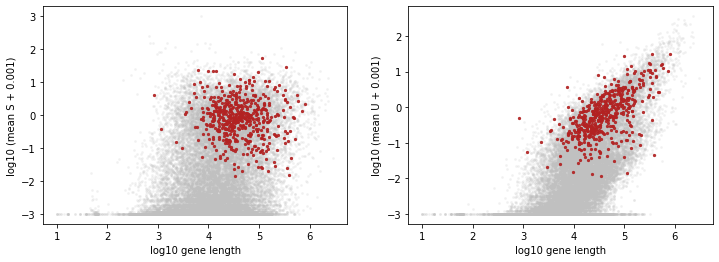

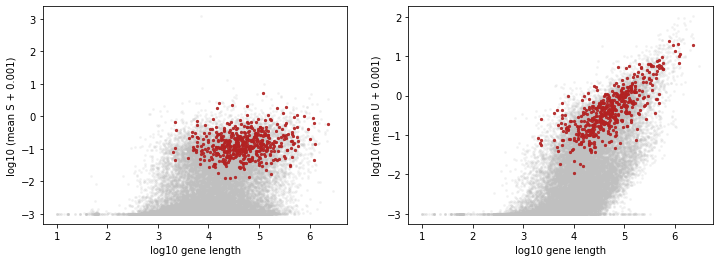

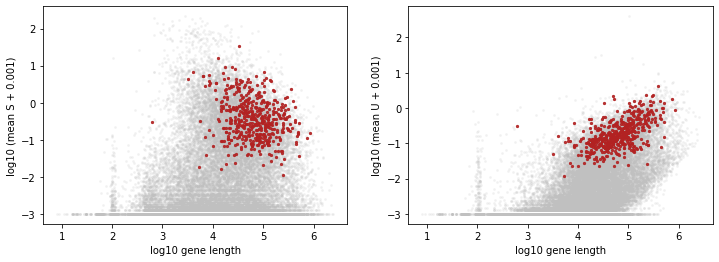

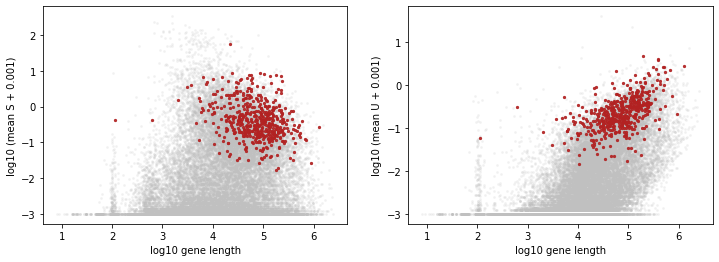

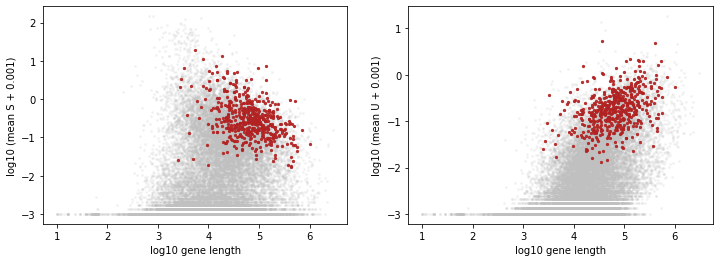

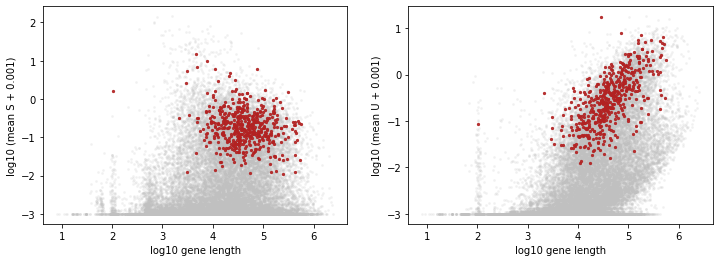

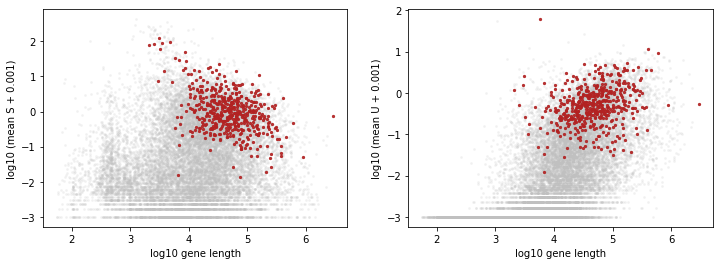

In [296]:
result_strings = []
for i in range(len(data_strings)): 
    #Set biological model
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    #Set up inference params
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                data_strings[i][0],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    
    #Get object for monod processing (from loom)
    
    search_data = monod.extract_data.extract_data(looms[i], transcrips[i], datas[i],
                data_strings[i][0], dir_strings[i], dataset_attr_names=attribute_names,)
    
    #Run inference
    start = timer()
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    end = timer()
    print((end - start)/3600,' hr')

    result_strings.append(full_result_string)

In [348]:
result_strings

['./fits/techruns_0208/gg_240208_025_allen_b08_1/allen_b08/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_allen_b02h01_1/allen_b02h01/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_cl3_1/cl3/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_cl5_1/cl5/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_brca1_1/brca1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_pbmc_1/pbmc/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/techruns_0208/gg_240208_025_e11e13_1/e11e13/Bursty_Poisson_10x11/grid_scan_results.res']

allen_b08   (-6.777777777777778, -1.25)
allen_b02h01   (-6.777777777777778, -1.25)
cl3   (-6.777777777777778, -1.25)
cl5   (-6.777777777777778, -0.6999999999999997)
brca1   (-6.777777777777778, -0.6999999999999997)
pbmc   (-5.666666666666666, -0.6999999999999997)
e11e13   (-6.777777777777778, -1.25)


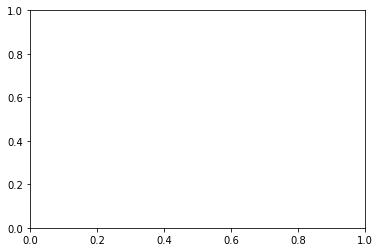

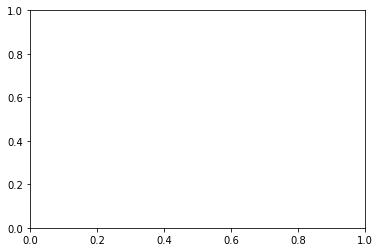

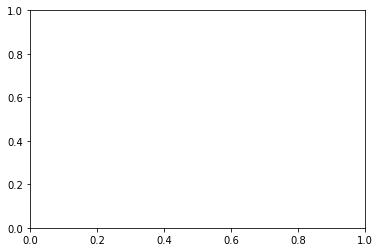

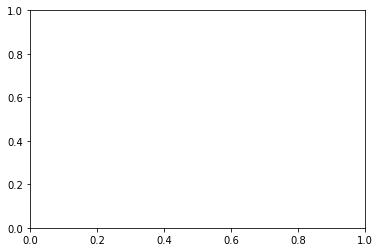

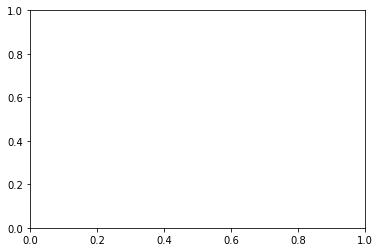

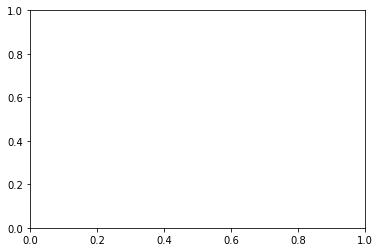

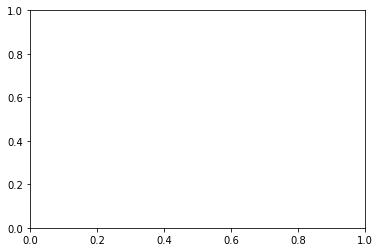

In [298]:
opts = []
for i in range(len(data_strings)): 
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_strings[i]+'/'+datas[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    print(datas[i],' ',sr.samp_optimum)
    opts += [sr.samp_optimum]

In [344]:
#Save number of unique labels

num_uniq = []
for l in looms:
    ds = lp.connect(l)
    if 'subclass_label' in list(ds.ca.keys()):
        num_uniq += [len(np.unique(ds.ca['subclass_label']))]
    else:
        num_uniq += [-1]
    ds.close()

In [345]:
num_uniq

[10, 11, 3, 5, -1, -1, 2]

In [346]:
techs = pd.DataFrame()
techs['Dataset'] = datas
techs['Transcrip'] = transcrips
techs['Clusters'] = num_uniq
techs['Cu'] = [list(o)[0] for o in opts]
techs['Lam'] = [list(o)[1] for o in opts]
techs.head()

,Dataset,Transcrip,Clusters,Cu,Lam
0,allen_b08,/home/tchari/perturbCME/notebooks/gg_200524_mo...,10,-6.777778,-1.25
1,allen_b02h01,/home/tchari/perturbCME/notebooks/gg_200524_mo...,11,-6.777778,-1.25
2,cl3,/home/tchari/perturbCME/notebooks/gg_200525_ge...,3,-6.777778,-1.25
3,cl5,/home/tchari/perturbCME/notebooks/gg_200525_ge...,5,-6.777778,-0.70
4,brca1,/home/tchari/perturbCME/notebooks/gg_200524_mo...,-1,-6.777778,-0.70


In [347]:
techs.to_csv('meKMeans_data_samp_params.csv',index=None)

In [322]:
# data_strings